# 基于Darts的股票价格时间序列预测

Python的darts包是一个用于时间序列预测和分析的库。它提供了丰富的功能来处理时间序列数据，包括数据预处理、特征提取、模型构建、预测及评估等。Darts特别适用于进行时间序列的深度学习模型构建，如RNNs、LSTMs等，同时也支持传统的统计方法和机器学习模型。此外，它还允许用户方便地比较不同模型性能，以及进行模型的组合以进一步提升预测准确性。总之，darts包是进行时间序列分析和预测任务的一个强大工具。


参考资料：


https://www.kaggle.com/code/stpeteishii/google-stock-prediction-darts

https://github.com/unit8co/darts#forecasting-models

https://github.com/unit8co/darts/blob/master/examples/09-DeepTCN-examples.ipynb


多变量与单变量

https://www.163.com/dy/article/IVNUJI3U0531D9VR.html


4大类11种常见的时间序列预测方法

https://zhuanlan.zhihu.com/p/472739821

In [1]:
import sqlite3
import pandas as pd  
# define prediction period
from datetime import datetime
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta
from darts.metrics import mape, smape

%matplotlib inline 
#正常显示画图时出现的中文和负号
from pylab import mpl

mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

## darts的时间序列的构建和操作


TimeSeries 是 Darts 中的主要数据类。TimeSeries 表示一个具有合适时间索引的单变量或多变量时间序列。时间索引可以是 pandas.DatetimeIndex 类型（包含日期时间），或者是 pandas.RangeIndex 类型（包含整数；对于表示没有特定时间戳的顺序数据很有用）。在某些情况下，TimeSeries 甚至可以表示概率序列，以便例如获得置信区间。Darts 中的所有模型都要求 TimeSeries 并且输出结果也是 TimeSeries。

读取数据并构建 TimeSeries
TimeSeries 可以使用几个工厂方法轻松构建：

对于 Pandas DataFrame，通过 TimeSeries.from_dataframe() 转换。

时间索引和对应的值数组，通过 TimeSeries.from_times_and_values() 转换。

NumPy 值数组，通过 TimeSeries.from_values() 转换。

Pandas Series，通过 TimeSeries.from_series() 转换。

xarray.DataArray，通过 TimeSeries.from_xarray() 转换。

CSV 文件，使用 TimeSeries.from_csv() 转换。

In [2]:
conn=sqlite3.connect(r'F:\BaiduNetdiskDownload\stock_2018_daily\stock_2018.db')
stock_ml=pd.read_sql("select * from stock_daily where 股票代码>'002500.SZ' and 交易日期>'20210217'",con=conn)
stock_ml.columns=['index', 'date', '股票代码', '股票简称', 'open', 'high', 'low', 'close', 'volume',
           '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率',
           '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)',
           '总市值(万元)', '流通市值(万元)']

In [3]:
stork_byd=stock_ml[stock_ml["股票代码"]=="002594.SZ"][["date","close"]].copy()

In [4]:
stork_byd["date"]=pd.to_datetime(stork_byd["date"].astype(str))

In [5]:
stork_byd

,date,close
44189,2021-02-18,264.1698
44190,2021-02-19,262.4970
44191,2021-02-22,244.3104
44192,2021-02-23,229.5000
44193,2021-02-24,213.1698
...,...,...
44670,2023-02-13,288.0511
44671,2023-02-14,287.6940
44672,2023-02-15,284.6637
44673,2023-02-16,282.6435


In [5]:
start0 = datetime.strptime('2021-02-18','%Y-%m-%d').date()
end0   = datetime.strptime('2023-02-17','%Y-%m-%d').date()
dates0=[]
for i in range(1,(end0-start0).days):
    dates0+=[(start0+timedelta(i)).strftime('%Y-%m-%d') ]

In [6]:
data3=pd.DataFrame(columns=['date'],data = dates0)
data3['date']=pd.to_datetime(data3['date'])
data3=data3.merge(stork_byd,how='left',on='date')
data3=data3.ffill()

In [7]:
series_stock=TimeSeries.from_dataframe(data3, time_col='date', value_cols='close')
print(type(series_stock))

<class 'darts.timeseries.TimeSeries'>


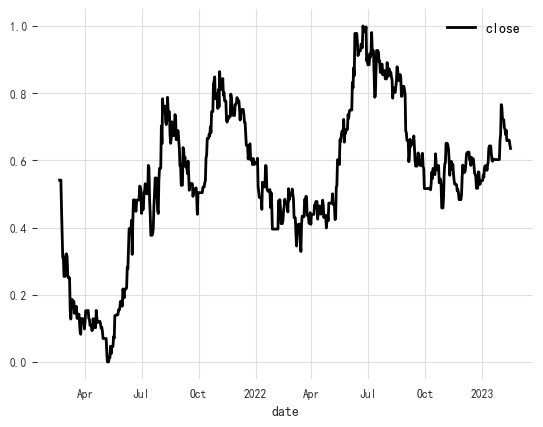

In [8]:
scaler_stock = Scaler()
stock_scaled = scaler_stock.fit_transform(series_stock)
stock_scaled.plot(label='close')
plt.legend(loc='best')

## 基本训练流程

In [9]:
train_stock, val_stock = stock_scaled[:600], stock_scaled[600:]
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=50, random_state=0)
model.fit(train_stock, verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=50, random_state=0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

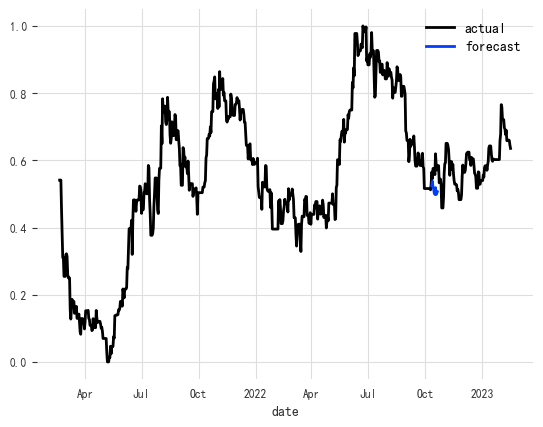

In [12]:
pred = model.predict(n=10, series=train_stock)
stock_scaled.plot(label='actual')
pred.plot(label='forecast')
plt.legend()

## 模型评价与可视化

平均绝对百分比误差（MAPE）darts.metrics包含了更多的指标来比较时间序列。当两个序列未对齐时，这些指标只会比较序列中共有的切片部分

**概率预测** 不仅仅提供点预测，还提供可能的未来结果分布。这些输出分布代表了不同未来值发生的可能性，允许在不确定性下进行更加明智的决策。比如说在观测值严格为正的情况下，如销售量或能耗，概率预测可能使用对数正态或伽玛分布来模拟可能结果的范围。概率预测在风险管理和规划中特别有用，因为它使利益相关者能够评估从最悲观到最乐观的各种情景的可能性。

在Darts库中，`historical_forecasts`方法主要用于进行回测（backtesting）和评估时间序列预测模型的性能。此方法通过模拟历史预测的方式工作，即在每个时间点上，它使用到那时为止的观测数据来训练或重训模型，然后预测接下来的一段时期（由`forecast_horizon`参数定义）。这个过程沿着时间轴逐步向前推进，从而生成一系列的预测，这些预测可以与实际发生的值进行比较，以评估模型的准确性和稳定性。

`historical_forecasts`的主要作用和特点包括：

1. **模型验证**：提供了一种无偏见的方法来估计模型在未知数据上的表现，因为每个预测都是基于模型在不包括预测时间段的数据上训练得出的。

2. **性能评估**：通过比较预测值和实际值，可以计算各种误差指标（如MAE、MSE、RMSE、MAPE等），进而评估模型的预测精度。

3. **参数调优**：根据回测结果，可以调整模型参数以优化预测性能。

4. **不确定性估计**：如果模型支持概率预测，`historical_forecasts`还可以用于评估预测的不确定性，比如通过计算预测区间来理解预测的可靠性。

5. **模型比较**：通过在相同的历史预测框架下比较不同模型的表现，可以选择最适合特定数据集的模型。

使用此方法时，开发者通常需要指定如下关键参数：
- **forecast_horizon**：预测的期数，即向前看多少个时间步。
- **retrain**：一个布尔值，指示在每个时间步是否重新训练模型。
- **start**：开始进行历史预测的起始时间点。
- **end**：历史预测结束的时间点（可选）。
- **verbose**：是否打印预测过程的详细信息。

通过这种方式，`historical_forecasts`为时间序列预测模型的开发和评估提供了一个强大的工具，帮助数据科学家和分析师更好地理解和优化他们的预测模型。

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

model NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0) obtains MAPE: 27.75%


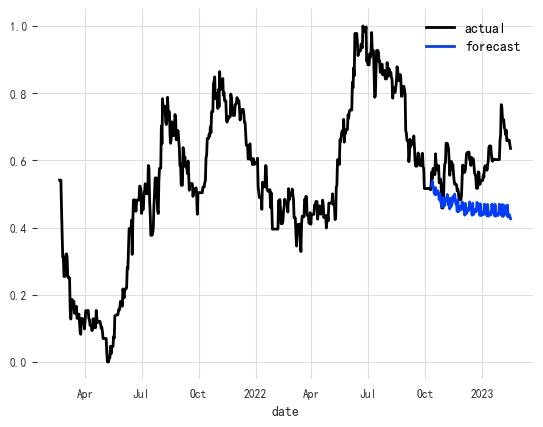

In [18]:
pred = model.predict(n=len(val_stock), series=train_stock)
print("model {} obtains MAPE: {:.2f}%".format(model, mape(pred,val_stock)))
stock_scaled.plot(label='actual')
pred.plot(label='forecast')
plt.legend()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE = 5.83%


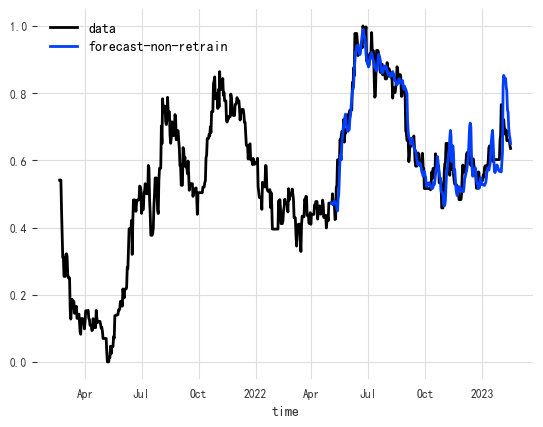

In [19]:
historical_fcast_theta = model.historical_forecasts(
    stock_scaled, start=0.6, forecast_horizon=3, verbose=True, retrain=False
)

stock_scaled.plot(label="data")
historical_fcast_theta.plot(label="forecast-non-retrain")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, stock_scaled)))

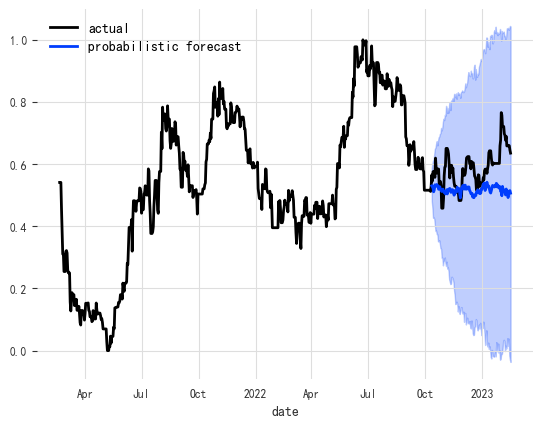

In [20]:
model_es = ExponentialSmoothing()
model_es.fit(train_stock)
probabilistic_forecast = model_es.predict(len(val_stock), num_samples=200)

stock_scaled.plot(label="actual")
probabilistic_forecast.plot(label="probabilistic forecast")
plt.legend()
plt.show()

## 模型的参数与分类

https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html#darts.models.forecasting.nbeats.NBEATSModel.save

Darts库提供了一系列丰富的时间序列预测模型，这些模型大致可以分为以下几类：

* 统计和经典方法
1. **ARIMA** (`ARIMA`)：自动回归积分滑动平均模型，用于处理线性趋势和周期性。
   - 参数包括`p`（自回归项）、`d`（差分次数）、`q`（滑动平均项）等。

2. **ExponentialSmoothing** (`ExponentialSmoothing`)：指数平滑法，适用于具有趋势和季节性的序列。
   - 参数有平滑类型（如`'simple'`, `'holt'`, `'winter'`）、平滑参数等。

* 深度学习模型
1. **NBEATS** (`NBEATSModel`)：神经基函数展开分析模型，擅长捕捉多种频率的周期性。
   - 参数包括`input_chunk_length`、`output_chunk_length`、是否使用堆叠层（`generic_architecture`）等。

2. **RNNModel** (`RNNModel`)：基于循环神经网络的模型，如LSTM或GRU。
   - 参数涵盖单元类型、层数、隐藏层大小、是否使用双向结构等。

3. **TCNModel** (`TCNModel`)：时间卷积网络模型，适合长序列预测。
   - 参数包括卷积核大小、层数、 dilation_base等。

4. **TransformerModel** (`TransformerModel`)：基于自注意力机制的模型，适用于复杂序列模式。
   - 参数涉及头数、层深、隐藏尺寸等。

* 混合模型
1. **RegressionModel** (`RegressionModel`)：可包装Scikit-learn或其他回归模型，灵活适应多种回归策略。
   - 参数包括内部回归模型的选择、是否进行概率预测等。

* 高级模型与集成方法
1. **EnsembleModel** (`EnsembleModel`)：模型集成，可以组合多个基础模型的预测。
   - 参数主要是组合的模型列表。

2. **Theta** (`Theta`)：Theta方法，专为季节性时间序列设计。
   - 参数相对较少，主要涉及季节性周期。

* 预测后处理
1. **ProbabilisticForecast`接口的模型：如`QuantileRegression`，提供概率预测能力。

* 特殊用途模型
1. **ProphetModel** (`ProphetModel`)：Facebook开源的Prophet模型的封装，适合具有强季节性和趋势的时间序列。
   - 参数包括节假日效应、季节性模式等。

* 自定义模型
Darts也支持自定义模型，用户可以根据需求实现自己的模型类，继承自基本的模型接口。

* 参数差异
1. **输入输出长度**：大多数模型都有`input_chunk_length`和`output_chunk_length`参数，分别控制模型观察过去的序列长度和预测未来的序列长度。
2. **模型复杂度**：深度学习模型通常有更多的参数来调整网络结构，如层数、节点数、卷积核大小等。
3. **协变量支持**：某些模型支持额外的协变量输入，如`add_encoders`参数，允许模型利用外部信息。
4. **预测类型**：部分模型支持概率预测，需要指定似然函数等参数。

总体而言，Darts模型的多样性允许用户针对不同时间序列特性和预测需求选择最合适的模型，并通过调整参数来优化预测性能。

## 模型参数

神经基函数展开分析时间序列预测（N-BEATS）

参数：
- input_chunk_length（int）：作为模型输入的时间步数（每块）。应用于目标序列，以及过去和/或未来的协变量（如果模型支持）。

- output_chunk_length（int）：内部模型一次预测的时间步数（每块）。同时也是作为模型输入使用的未来协变量的未来值数量（如果模型支持未来协变量）。这与predict()中使用的预测期n不相同，n是使用一次性或自回归预测生成的所需预测点数。设置n <= output_chunk_length可以防止自回归。当协变量没有延伸到足够远的未来时，或者为了禁止模型在预测时使用过去和/或未来协变量的未来值（取决于模型的协变量支持）时，这一点很有用。

- output_chunk_shift（int，可选）：如有需要，可以在输入块结束后的未来方向上，将输出块的起始点移动的步数。这将在输入和输出之间创建一个间隙。如果模型支持future_covariates，则从移动后的输出块中提取未来值。预测将从目标序列结束后的output_chunk_shift步开始。如果设置了output_chunk_shift，模型无法生成自回归预测（n > output_chunk_length）。

- likelihood (可选[str]) – 可以设置为'quantile'或'poisson'。如果设置了此参数，模型将成为概率模型，允许在预测时进行抽样。这将覆盖任何目标函数参数。

LGBM 模型

参数
- lags (Union[int, List[int], Dict[str, Union[int, List[int]]], None]) – 用于预测下一时间步或时间步序列的滞后目标序列值。如果是一个整数，必须大于0。使用最后n=lags个过去的时间滞后值；例如（-1, -2, …, -lags），其中0对应于每个样本的第一个预测时间步。如果output_chunk_shift > 0，则滞后-1转换为在第一个预测步之前的-1-output_chunk_shift步。如果是一个整数列表，每个值必须小于0。仅使用指定的值作为滞后。如果是一个字典，键对应于序列组件名称（当使用多个序列时为第一个序列的），值则对应于组件的滞后（整数或整数列表）。键'default_lags'可以用来为未指定的组件提供默认的滞后值。如果某些组件缺失且未提供'default_lags'键，将引发错误。

In [16]:
def eval_model(model):
    model.fit(train_stock)
    forecast = model.predict(len(val_stock))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val_stock, forecast)))
    return model


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())

model ExponentialSmoothing() obtains MAPE: 11.03%
model TBATS() obtains MAPE: 11.15%
model AutoARIMA() obtains MAPE: 10.87%


AutoARIMA(add_encoders=None)

In [ ]:
#rnn_model=eval_model(RNNModel(input_chunk_length=24, output_chunk_length=12, n_epochs=50, random_state=0))

In [ ]:
#eval_model(NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=50, random_state=0))

## 多变量时间序列的股价预测

**单变量时间序列预测** 侧重于使用单一时间序列变量的过去值来预测其未来值。预测模型依赖于该单一变量的历史数据来识别可以用来进行未来预测的模式、趋势和周期。例如，仅根据过去的温度记录来预测明天的温度。

**多变量时间序列预测** 涉及基于历史数据预测多个相关时间序列变量的未来值。在这种情况下，预测模型会考虑多个变量之间的相互依赖性和交互作用来进行预测。例如，预测产品的未来销售量可能不仅考虑过去的销售情况，还可能考虑市场支出、季节趋势和竞争对手的价格等相关因素。

**时间序列频率** 指的是时间序列中数据点的记录或观察间隔，代表了数据随时间的规律性和粒度。这种频率可以从高频数据（如金融市场中的分钟级交易）到低频数据（如年度经济指标）不等。不同的频率可以捕捉到各种趋势、模式和季节性。例如日常销售数据可能揭示出月度汇总中看不到的模式，如每周周期或特定日的影响。



In [10]:
stock_ml["date"]=stock_ml["date"].astype("str").astype("datetime64[ns]")

In [11]:
def darts_series(stock_id,tz):
    stock=stock_ml[stock_ml["股票代码"]==stock_id][["date",tz]].copy()

    start0 = stock["date"].min().date()
    end0   = stock["date"].max().date()
    dates0=[]
    print((end0-start0).days)
    for i in range(1,(end0-start0).days):
        dates0+=[(start0+timedelta(i)).strftime('%Y-%m-%d') ]
    data3=pd.DataFrame(columns=['date'],data = dates0)
    data3['date']=pd.to_datetime(data3['date'])

    data3=data3.merge(stock,how='left',on='date')
    data3=data3.ffill()
    
    series_stock=TimeSeries.from_dataframe(data3, time_col='date', value_cols=tz)
    scaler_stock = Scaler()
    stock_scaled = scaler_stock.fit_transform(series_stock)

    return stock_scaled

729


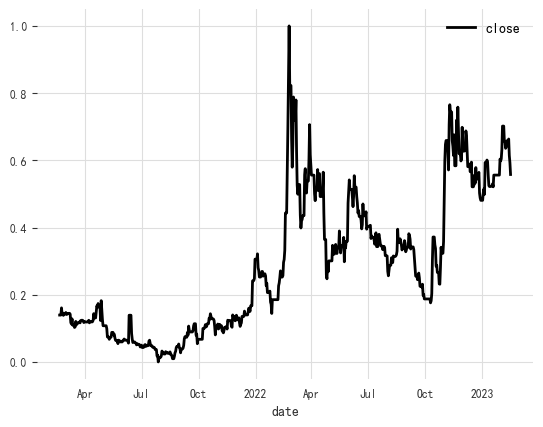

In [12]:
stock1=darts_series("002758.SZ","close")
stock1.plot(label='close')
plt.legend(loc='best')

729


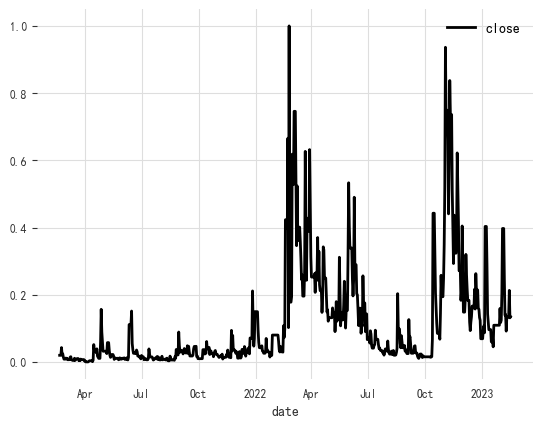

In [13]:
stock2=darts_series("002758.SZ","volume")
stock2.plot(label='close')
plt.legend(loc='best')

In [14]:
train_stock1, val_stock1 = stock1[:650], stock1[650:]
train_stock2, val_stock2 = stock2[:650], stock2[650:]
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=40, random_state=0)
model.fit([train_stock1,train_stock2], verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=40, random_state=0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

model NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=40, random_state=0) obtains MAPE: 40.70%


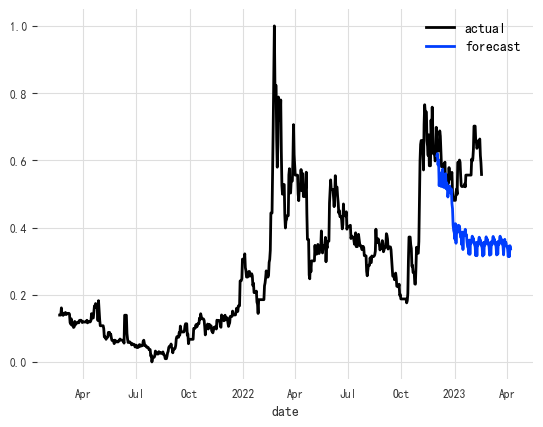

In [18]:
pred = model.predict(n=len(val_stock), series=train_stock1)
print("model {} obtains MAPE: {:.2f}%".format(model, mape(pred,val_stock1)))
stock1.plot(label='actual')
pred.plot(label='forecast')
plt.legend()

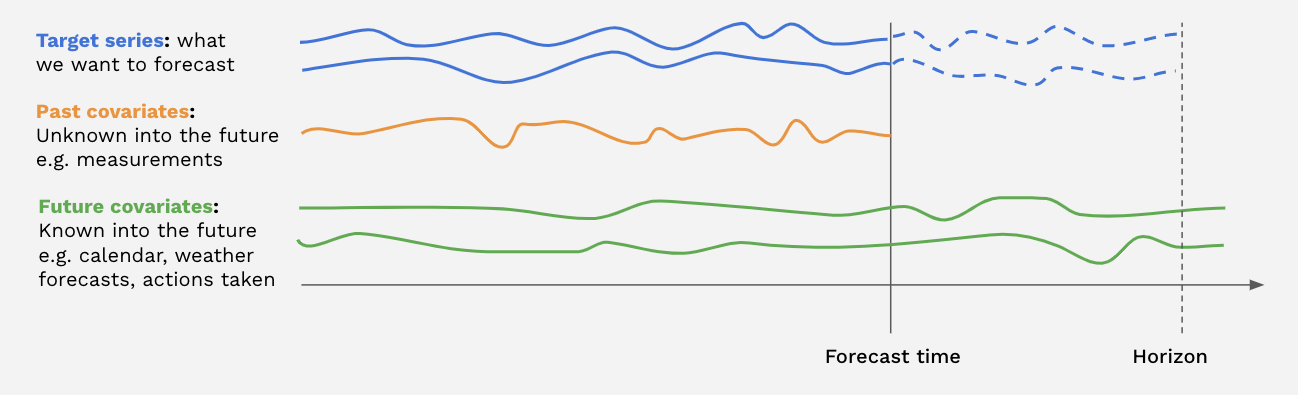

In [26]:
from IPython.display import Image
Image(filename="covariates-highlevel.png")

## 股价时间序列预测中的协变量使用

**时间序列预测中的协变量** 是可以影响预测结果的变量。这些变量可以提前知道或预估。在单变量和多变量预测模型中，协变量引入了目标变量历史数据之外的额外见解。例如，假日、特殊事件和经济指标等因素。此外，在多变量预测中，协变量扩展到包括相关的时间序列数据——这些可能是已知未来值或需要预测的变量（参见上述例子）。


除了目标序列（我们感兴趣的预测序列）外，Darts中的许多模型也接受输入协变量序列。协变量是我们不想预测但可以为模型提供有益额外信息的序列。目标序列和协变量序列都可以是多变量或单变量的。

在Darts中有两种协变量时间序列：

past_covariates是指不一定在预测时间之前已知的序列。例如，这些可以代表必须被测量且不能提前知晓的事物。模型在进行预测时不会使用past_covariates的未来值。

future_covariates是指直到预测周期都已提前知道的序列。这可以代表日历信息、节假日、天气预报等。接受future_covariates的模型在进行预测时会查看直到预测周期的未来值。

**协变量**

每个协变量都可能具有多变量性。如果你有多个协变量序列（比如月份和年份的值），你应该使用stack()或concatenate()函数将它们堆叠或连接起来以获得一个多变量序列。

你提供的协变量序列可以比实际需要的更长。Darts会尝试根据不同序列的时间索引来智能地对它们进行正确的切片以用于目标序列的预测。然而，如果你的协变量时间跨度不够，你会收到错误信息。

现在，让我们为“空气”和“牛奶”序列构建一些外部协变量，包含月度和年度的值。在下面的代码单元格中，我们使用darts.utils.timeseries_generation.datetime_attribute_timeseries()函数生成包含月份和年份值的序列，并通过concatenate()函数沿"component"轴将这些序列连接起来，以便为每个目标序列获得一个具有两个月份和年份两个分量的协变量序列。为了简化处理，我们直接将月份和年份的值缩放到了大约0到1之间：

### 构建协变量

In [30]:
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

air_covs = concatenate(
    [
        dt_attr(train_stock1.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(train_stock1.time_index, "year", dtype=np.float32) - 2020) / 12,
        train_stock2
    ],
    axis="component",
)

In [32]:
#air_covs

<Axes: xlabel='date'>

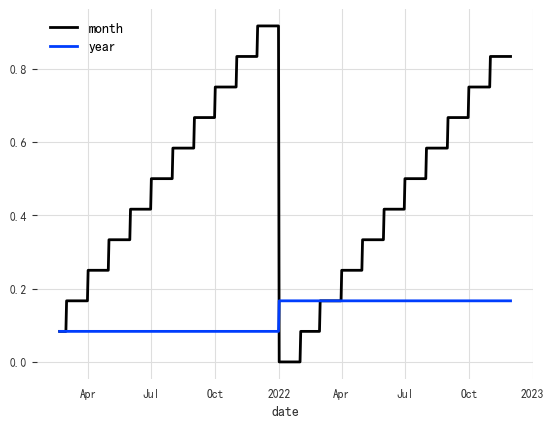

In [22]:
air_covs.plot()

### 协变量的使用

In [33]:
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit(
    train_stock1,
    past_covariates=train_stock2,
    epochs=50,
    verbose=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.6 M 
---------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
26.314    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, random_state=42)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

model NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42) obtains MAPE: 5.50%


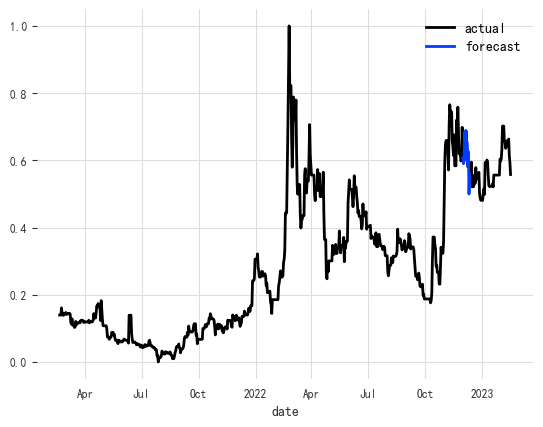

In [42]:
pred_air = model.predict(n=12,series=train_stock1, past_covariates=air_covs)
print("model {} obtains MAPE: {:.2f}%".format(model, mape(pred_air,val_stock1)))
stock1.plot(label='actual')
pred_air.plot(label='forecast')
plt.legend()

时间协变量的使用

- 月份应作为未来协变量使用，并采用周期性（正弦/余弦）编码。
- 小时和星期几应作为未来协变量使用。
- 绝对位置（序列中的时间步）应作为过去协变量使用。
- 相对位置（相对于预测时间的位置）应作为未来协变量使用。
- 年份的一个额外自定义函数应作为过去协变量使用。
  
所有上述协变量都应使用`Scaler`进行缩放，该`Scaler`将在调用模型的`fit()`函数时进行拟合，并随后用于转换协变量。这种方法确保了输入到模型中的协变量被标准化或归一化，有助于提高模型训练的稳定性和预测的准确性。

In [ ]:
def extract_year(idx):
    """Extract the year each time index entry and normalized it."""
    return (idx.year - 1950) / 50


encoders = {
    "cyclic": {"future": ["month"]},
    "datetime_attribute": {"future": ["hour", "dayofweek"]},
    "position": {"past": ["absolute"], "future": ["relative"]},
    "custom": {"past": [extract_year]},
    "transformer": Scaler(),
}

In [24]:
encoders = {"datetime_attribute": {"future": ["month", "year","dayofweek"]}, "transformer": Scaler()}

In [25]:
train_stock1, val_stock1 = stock1[:650], stock1[650:]
#train_stock2, val_stock2 = stock2[:650], stock2[650:]
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=50,add_encoders=encoders,random_state=0)
model.fit(train_stock1, verbose=True)

Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=50, add_encoders={'datetime_attribute': {'future': ['month', 'year', 'week']}, 'transformer': Scaler}, random_state=0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

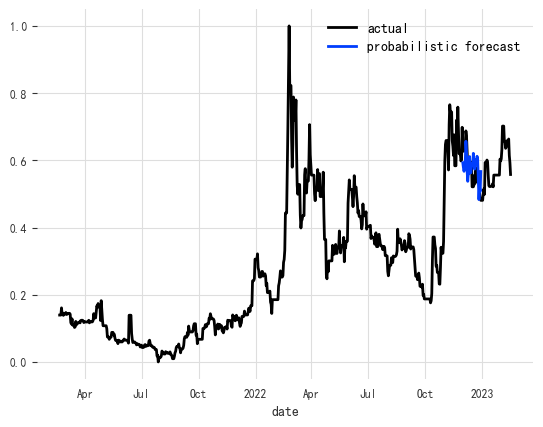

In [29]:
probabilistic_forecast = model.predict(30,series=train_stock1)

stock1.plot(label="actual")
probabilistic_forecast.plot(label="probabilistic forecast")
plt.legend()
plt.show()